In [1]:
#Let's read in some athletes, check their races, and see if a fit model on their first race
#can be used to predict future races.

In [3]:
#Imports borrowed from pymc3_modeling.ipynb
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
from scipy.integrate import odeint
size = (12, 9)

import json
import datetime as dt

import re
import os
import glob

import arviz as az
import theano
import theano.tensor as tt
import statsmodels.api as sm
import pymc3 as pm
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from pandas.plotting import register_matplotlib_converters
plt.style.use('seaborn')
register_matplotlib_converters()

In [4]:
#Read in the athlete dictionary:
with open("./data/athletes.json") as json_file: 
    athletes = json.load(json_file)

In [34]:
def analyze_file(filepath, sport, athlete_id): #Athlete id is a number no need to pass it the string:
    '''
    This function takes in a file, converts all the columns to numeric and date that we need,
    creates a speed column for running that converts pace to speed in ft/s, and prepares the 
    columns for the fit function that will later be used to predict the running pace. It will 
    create and output all the graphs we have here, for each of the races in the filepath.
    '''
    #Read in the dataframe:
    raw = pd.read_csv(filepath)
    sport = sport
    athlete_max_hr = athletes[str(athlete_id)]['max_hr']
    #Filter down just to the sport:
    df = raw[raw['activity_type'] == sport]
    
    
    #Setting average pace to a timedelta, we use a try in case the data does not have avg_pace column:
    try:
        df['avg_pace'] = pd.to_timedelta(df['avg_pace'])
    except:
        print("No avg_pace column!")
    
    try:
        df['distance'] = pd.to_numeric(df['distance'])
    except:
        print(f"Check athlete #{athlete_id} at filepath ###{filepath}###")
    
    try:
        df['elev_gain'] = pd.to_numeric(df['elev_gain'].str.replace(',', ''))
    except:
        try:
            df['elev_gain'] = pd.to_numeric(df['elev_gain'])
        except:
            print(f"Check athlete #{athlete_id} at filepath ###{filepath}###")
    
    #Create ft/mile column and intensity for analysis:
    try:
        df['ft_per_mile'] = (df['elev_gain']/df['distance'])
    except:
        df['ft_per_mile']=0
        
    df['intensity'] = df['avg_hr']/athlete_max_hr
    
       
    
    
    
    #Do the same for calculating speed in ft/s
    df['spd_ft_s'] = 0.0
    df['spd_mph'] = 0.0
    df.reset_index(inplace=True)
    
    for i in range(len(df['avg_pace'])):
        try:
        #.total_seconds returns the total seconds in a timedelta object.
            df['spd_mph'][i] = float(60/(df['avg_pace'][i].total_seconds()/60.0))
            #takes the speed in miles per hour and converts down to ft/s
            df['spd_ft_s'][i] = float(60.0/(df['avg_pace'][i].total_seconds()/60.0))*float(5280.0/3600.0)
        except:
            df['spd_mph'][i] = 0
            df['spd_ft_s'][i] = 0
        
    #The default is to be equal to the speed not taking into account elevation gain.
    df['GAP_ft_s'] = df['spd_ft_s']
    
    #Now we try to make a GAP column:
    for i in range(len(df)):
        #Try to make a GAP column:
        try:
            #using trig to calculate the change to the pace:
            factor = (np.sqrt((df['distance'][i]*5280)**2+df['elev_gain'][i]**2)/(df['distance'][i]*5280))
            df['GAP_ft_s'][i] = factor*df['spd_ft_s'][i]
        except:
            print("No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.")
        
    #Why divide by intensity? This brings average run pace up to the speed that we would expect if the athlete was at their highest average
    #sustainable heartrate for this speed. 
    df['GAP_by_intensity']  = df['GAP_ft_s']/df['intensity']
    
    #This creates a finalized dataframe with all of the columns I need for creating the pace curves.
    df.to_csv(filepath[:-4]+'_'+sport+'_extra_cols.csv')

In [7]:
files_to_convert = glob.glob('./data/clean/garmin_clean/*')

In [8]:
files_to_convert

['./data/clean/garmin_clean/clean_6.csv',
 './data/clean/garmin_clean/clean_7.csv',
 './data/clean/garmin_clean/clean_5.csv',
 './data/clean/garmin_clean/clean_4.csv',
 './data/clean/garmin_clean/clean_0.csv',
 './data/clean/garmin_clean/clean_1.csv',
 './data/clean/garmin_clean/clean_3.csv',
 './data/clean/garmin_clean/clean_2.csv',
 './data/clean/garmin_clean/clean_12.csv',
 './data/clean/garmin_clean/clean_11.csv',
 './data/clean/garmin_clean/clean_10.csv',
 './data/clean/garmin_clean/clean_3_Running_extra_cols.csv',
 './data/clean/garmin_clean/clean_9.csv',
 './data/clean/garmin_clean/clean_8.csv']

In [35]:
#Going to do these manually, I am running low on time to automate stuff for now:
analyze_file('./data/clean/garmin_clean/clean_0.csv', 'Running', 0)
analyze_file('./data/clean/garmin_clean/clean_1.csv', 'Running', 1)
analyze_file('./data/clean/garmin_clean/clean_2.csv', 'Running', 2)
analyze_file('./data/clean/garmin_clean/clean_3.csv', 'Running', 3)
analyze_file('./data/clean/garmin_clean/clean_4.csv', 'Running', 4)
analyze_file('./data/clean/garmin_clean/clean_5.csv', 'Running', 5)
analyze_file('./data/clean/garmin_clean/clean_6.csv', 'Running', 6)
analyze_file('./data/clean/garmin_clean/clean_7.csv', 'Running', 7)
analyze_file('./data/clean/garmin_clean/clean_8.csv', 'Running', 8)
analyze_file('./data/clean/garmin_clean/clean_9.csv', 'Running', 9)
analyze_file('./data/clean/garmin_clean/clean_10.csv', 'Running', 10)
analyze_file('./data/clean/garmin_clean/clean_11.csv', 'Running', 11)
analyze_file('./data/clean/garmin_clean/clean_12.csv', 'Running', 12)




Check athlete #2 at filepath ###./data/clean/garmin_clean/clean_2.csv###
No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.
No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.
No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.
No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.
No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.
No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.
No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.
No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.
No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.
No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.
No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.
No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.
No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.
No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.
No 

Let's see if our Pymc3 fit can be applied to other athlete's races:

In [113]:
def get_athlete_param(athlete_id):
    '''
    Function takes in an athlete, and calculates their expected athlete characteristic 
    variable.
    '''
    print(f'Athlete Id is {athlete_id}')
    df= pd.read_csv(f'./data/races/athlete_{athlete_id}/athlete_{athlete_id}_race_1_3_mo_Running_extra_cols.csv', index_col='date')
    print('Dataframe read in successfully.')
    pace_trend = df['spd_ft_s']/df['intensity']
    print('Pace Trend found.')
    
    #Convert the index to a date time and drop any duplicates (sometimes runners have two runs a day)
    pace_trend.index = pd.to_datetime(pace_trend.index).normalize()
    pace_trend = pace_trend[~pace_trend.index.duplicated(keep='first')]
    
    #Reindex and fill the df keeping pace constant until changed.
    full_date_range = pd.date_range(start = pace_trend.index[0], end=pace_trend.index[-1])
    pace_trend = pace_trend.reindex(index = full_date_range)
    pace_trend = pace_trend.fillna(method='pad')
    pace_trend = pace_trend.resample('W').mean()
    print(len(pace_trend))
    #Instantiate and fit a nn:
    x = range(len(pace_trend))
    
    with pm.Model() as run_model:
    
        s = pm.Uniform('s', lower = -5, upper = 5)
        c = pm.Normal('c', mu = len(pace_trend)/2, sd = 2)
        sd = pm.Uniform('sd', lower = 0, upper = 3)
        offset = pm.Uniform('off', lower = 0, upper = 15)
        line = s/(1+np.exp((-(x-c))/s)) + offset
        y = pm.Normal('y', mu = line, sd = sd, observed = pace_trend)

        trace = pm.sample(1000, target_accept = 0.95)
    print(trace['s'].mean())
    print(trace['c'].mean())
    print(trace['off'].mean())
    
    plt.plot(x, pace_trend)
    s_final = trace['s'].mean()
    c_final = trace['c'].mean()
    off_final = trace['off'].mean()
    plt.plot(x, (s_final/(1+np.exp((-(x-c_final))/s_final)) + off_final))

Athlete Id is 3
Dataframe read in successfully.
Pace Trend found.
14


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [off, sd, c, s]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:09<00:00, 604.15draws/s] 
The number of effective samples is smaller than 25% for some parameters.


0.09615244383841665
5.78861060556172
14.6718998451166


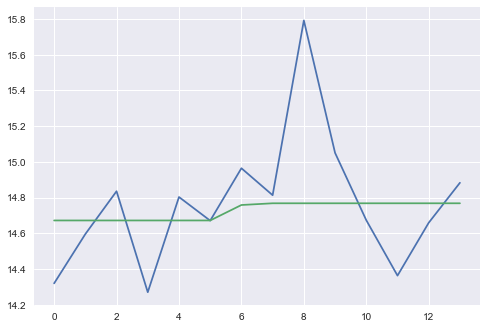

In [114]:
get_athlete_param(3)